In [2]:
from azureml.core import Workspace, Dataset, Experiment

ws = Workspace.from_config()

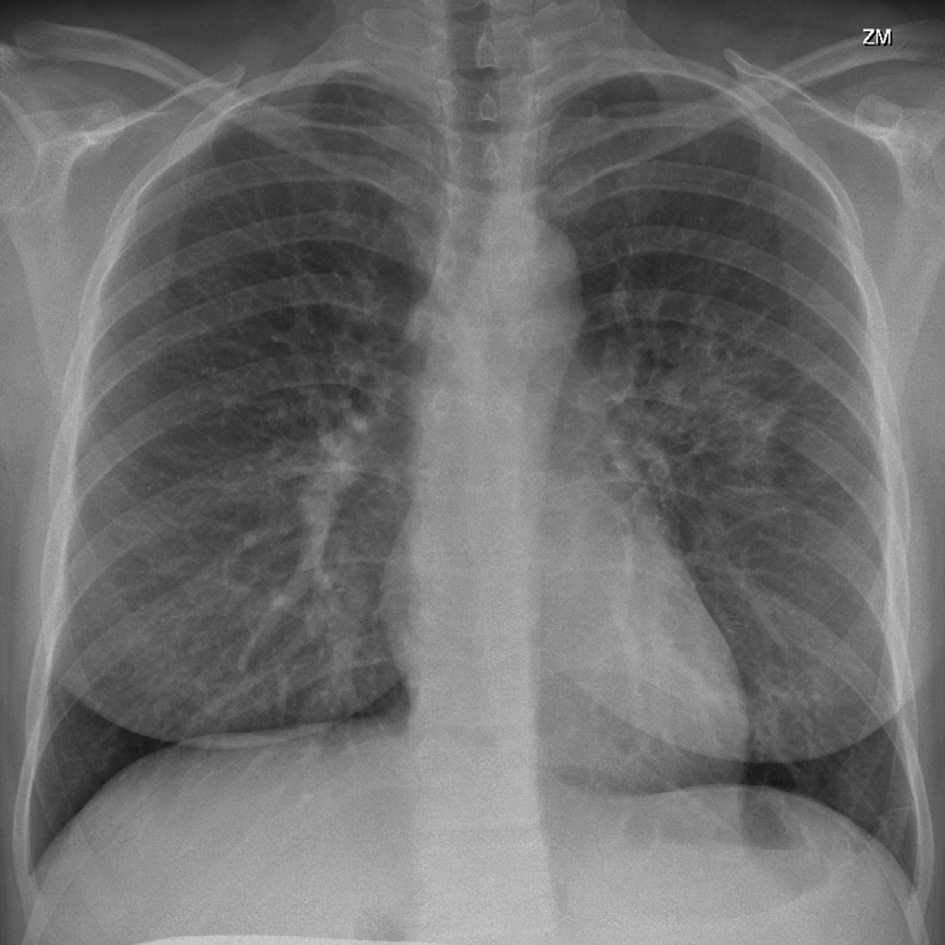

In [3]:
from IPython.display import Image
sample_image = "./Xray/Covid/COVID19(59).jpg"
Image(filename=sample_image)

In [4]:
import json
import os
src = "./Xray/"
train_validation_ratio = 10

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, "train_annotations.jsonl")
validation_annotations_file = os.path.join(src, "validation_annotations.jsonl")

# sample json line dictionary
json_line_sample = {
    "image_url": "AmlDatastore://"
    + workspaceblobstore
    + "/"
    + os.path.basename(os.path.dirname(src)),
    "label": "",
}

index = 0
# Scan each sub directary and generate jsonl line
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src):
            subDir = src + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./Xray/Covid
Parsing ./Xray/Normal
Parsing ./Xray/Pneumonia


In [5]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./Xray/", target_path="Xray")

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 158 files
Uploading ./Xray/.amlignore
Uploaded ./Xray/.amlignore, 1 files out of an estimated total of 158
Uploading ./Xray/.amlignore.amltmp
Uploaded ./Xray/.amlignore.amltmp, 2 files out of an estimated total of 158
Uploading ./Xray/train_annotations.jsonl
Uploaded ./Xray/train_annotations.jsonl, 3 files out of an estimated total of 158
Uploading ./Xray/train_annotations.jsonl.amltmp
Uploaded ./Xray/train_annotations.jsonl.amltmp, 4 files out of an estimated total of 158
Uploading ./Xray/validation_annotations.jsonl
Uploaded ./Xray/validation_annotations.jsonl, 5 files out of an estimated total of 158
Uploading ./Xray/validation_annotations.jsonl.amltmp
Uploaded ./Xray/validation_annotations.jsonl.amltmp, 6 files out of an estimated total of 158
Uploading ./Xray/Covid/.amlignore
Uploaded ./Xray/Covid/.amlignore, 7 files out of an estimated total of 158
Uploading ./Xray/Covid/.amlignore.amltmp
Uploaded ./Xray/Covid/.amlignore.amltmp, 8 files out of an estimat

$AZUREML_DATAREFERENCE_753089b308df48d7a367399359c65fa4

In [6]:
from azureml.core import Dataset
from azureml.data import DataType

# get existing training dataset
training_dataset_name = "XrayTrainingDataset"
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print("Found the training dataset", training_dataset_name)
else:
    # create training dataset 
    training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("Xray/train_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    training_dataset = training_dataset.register(
        workspace=ws, name=training_dataset_name
    )
# get existing validation dataset
validation_dataset_name = "XrayValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print("Found the validation dataset", validation_dataset_name)
else:
    # create validation dataset
    validation_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path("Xray/validation_annotations.jsonl"),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    validation_dataset = validation_dataset.register(
        workspace=ws, name=validation_dataset_name
    )
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Training dataset name: XrayTrainingDataset
Validation dataset name: XrayValidationDataset


In [7]:
training_dataset.to_pandas_dataframe()

image_url      label
0        workspaceblobstore/Xray/Covid/COVID19(59).jpg      Covid
1         workspaceblobstore/Xray/Covid/COVID19(6).jpg      Covid
2        workspaceblobstore/Xray/Covid/COVID19(60).jpg      Covid
3        workspaceblobstore/Xray/Covid/COVID19(61).jpg      Covid
4        workspaceblobstore/Xray/Covid/COVID19(62).jpg      Covid
..                                                 ...        ...
130  workspaceblobstore/Xray/Pneumonia/person994_vi...  Pneumonia
131  workspaceblobstore/Xray/Pneumonia/person995_ba...  Pneumonia
132  workspaceblobstore/Xray/Pneumonia/person995_vi...  Pneumonia
133  workspaceblobstore/Xray/Pneumonia/person996_vi...  Pneumonia
134  workspaceblobstore/Xray/Pneumonia/person9_bact...  Pneumonia

[135 rows x 2 columns]